In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
#4 RVs corresponding to 4 sets of likelihood: x_l,x_r | z_l,z_r = 0,0; 0,1; 1,0; 1,1
# dimension of image: D
# no. basis: N
# sigma_n: added noise to image
# sigma_y: std of prior on activation

In [3]:
#calculate posterior of z_l, z_r given x_l, x_r, W, sigma_n, sigma_y in the posterior function
def posterior(x_l, x_r, W, sigma_n, sigma_y):
    N = len(x_l)
    I = np.eye(N)
    zero_matrix = np.zeros((N,N))

    #generate covariance matrix
    cov00_0 = np.hstack((sigma_n**2*I, zero_matrix))
    cov00_1 = np.hstack((zero_matrix, sigma_n**2*I))
    cov_00 = np.vstack((cov00_0, cov00_1)) + np.eye(2*N)*10**(-12)

    cov01_0 = np.hstack((sigma_n**2*I, zero_matrix))
    cov01_1 = np.hstack((zero_matrix, sigma_y**2*W@W.T + sigma_n**2*I))
    cov_01 = np.vstack((cov01_0, cov01_1)) + np.eye(2*N)*10**(-12)

    cov10_0 = np.hstack((sigma_y**2*W@W.T + sigma_n**2*I,zero_matrix))
    cov10_1 = np.hstack((zero_matrix, sigma_n**2*I))
    cov_10 = np.vstack((cov10_0,cov10_1)) + np.eye(2*N)*10**(-12)

    cov11_0 = np.hstack((sigma_y**2*W@W.T + sigma_n**2*I, sigma_y**2*W@W.T))
    cov11_1 = np.hstack((sigma_y**2*W@W.T, sigma_y**2*W@W.T + sigma_n**2*I))
    cov_11 = np.vstack((cov11_0, cov11_1)) + np.eye(2*N)*10**(-12)

    #4rvs for 4 likelihood
    rv00 = stats.multivariate_normal(mean=None, cov = cov_00)
    rv01 = stats.multivariate_normal(mean=None, cov = cov_01)
    rv10 = stats.multivariate_normal(mean=None, cov = cov_10)
    rv11 = stats.multivariate_normal(mean=None, cov = cov_11)

    #r = raw, not normalized
    p_00_r = rv00.pdf(np.hstack((x_l,x_r)))
    p_01_r = rv01.pdf(np.hstack((x_l,x_r)))
    p_10_r = rv10.pdf(np.hstack((x_l,x_r)))
    p_11_r = rv11.pdf(np.hstack((x_l,x_r)))

    #normalization to get posterior
    return np.array([p_00_r,p_01_r,p_10_r,p_11_r]/(p_00_r+p_01_r+p_10_r+p_11_r))


In [4]:
#test fusion on random w for high SNR assumption to verify pi/2 threshold
def test_fusion(x_l,x_r):
    m = 200
    count = 0
    n = len(x_l)
    sigma_n = 0.2
    sigma_y = 20
    for i in range(m):
#   random w
        W = []
        for i in range(4*n):
            wi = np.random.randn(n)
            W.append(wi/np.linalg.norm(wi))

        W = np.array(W).T
        prob_list = []
        for c in np.linspace(0,10,100):
            x_l_i = c*x_l
            x_r_i = c*x_r
            prob_list.append(posterior(x_l_i, x_r_i, W, sigma_n, sigma_y))

        prob_list = np.array(prob_list)

        p11 = prob_list[:,3][np.isnan(prob_list[:,3]) == False]
        if p11[-1]>0.98:
            count = count+1
    return(count/m)

In [41]:
l = np.linspace(-1,1,50)
l_re = np.zeros(50)
j = 0
for i in l:
    xl = np.array([1,0])
    xr = np.array([i,(1-i**2)**0.5])
    l_re[j] = test_fusion(xl,xr)
    j = j+1

/var/folders/04/wzq37d2s3bv87g77m67thbk80000gn/T/ipykernel_97675/1225880988.py:37: RuntimeWarning: invalid value encountered in true_divide
  return np.array([p_00_r,p_01_r,p_10_r,p_11_r]/(p_00_r+p_01_r+p_10_r+p_11_r))


Text(0, 0.5, 'fusion proportion')

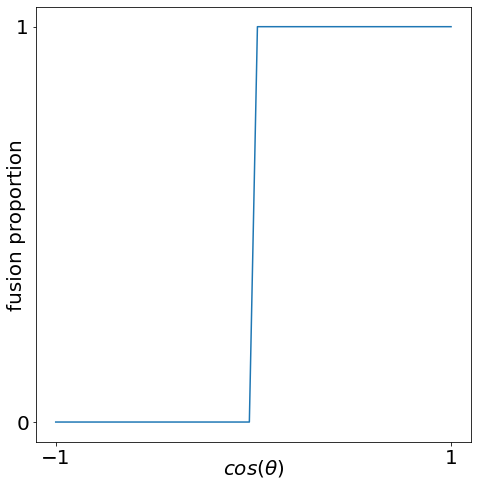

In [53]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots()
ax.plot(np.linspace(-1,1,50), l_re)
ax.set_box_aspect(1) #set the shape of plot to a square
ax.set_xticks([-1,1])
ax.set_yticks([0,1])
ax.set_xlabel(r"$cos(\theta)$",labelpad=-10) #labelpad=-10: move label upward
ax.set_ylabel('fusion proportion',labelpad=-10) #labelpad=-10: move label to the right

/var/folders/04/wzq37d2s3bv87g77m67thbk80000gn/T/ipykernel_97675/1225880988.py:37: RuntimeWarning: invalid value encountered in true_divide
  return np.array([p_00_r,p_01_r,p_10_r,p_11_r]/(p_00_r+p_01_r+p_10_r+p_11_r))


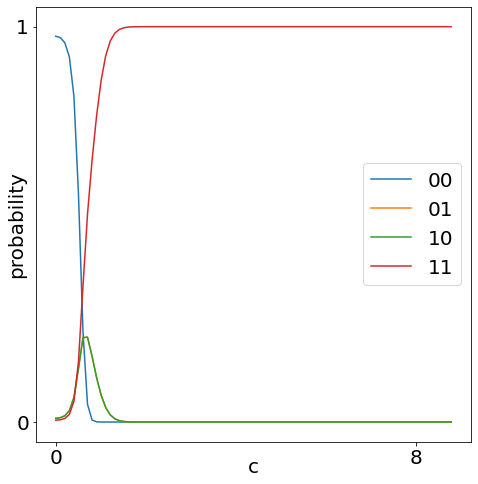

In [33]:
x_l = np.array([0.25,(1-0.25**2)**0.5])
x_r = np.array([1,0])
W = np.eye(2)
sigma_n = 0.2
sigma_y = 2
prob_list = []
for c in np.linspace(0,10,100):
    x_l_i = c*x_l
    x_r_i = c*x_r
    prob_list.append(posterior(x_l_i, x_r_i, W, sigma_n, sigma_y))

prob_list = np.array(prob_list)

'''plt.plot(prob_list)
plt.legend(['00','01','10','11'])
plt.xlabel('c')
plt.ylabel('probability')'''

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots()
ax.plot(np.linspace(0,10,100), prob_list)
ax.set_box_aspect(1) #set the shape of plot to a square
ax.set_xticks([0,8])
ax.set_yticks([0,1])
ax.set_xlabel('c',labelpad=-10) #labelpad=-10: move label upward
ax.set_ylabel('probability',labelpad=-10) #labelpad=-10: move label to the right
ax.legend(['00','01','10','11'])
fig.savefig('fus1.svg')

In [11]:
#test_fusion(np.array([0,1]),np.array([(1-0.01**2)**0.5,0.01]))

In [35]:
def test_snr(acc,sigma_n = 0.2):
    #alpha: cos of angle between x_l and x_r
    #snr: sigma_y^2/sigma_n^2
    #dim: dimension of image
    #acc: accuracy, no. evenly spaced sample on snr and alpha axis
    #W = I
    dim = 2
    W = np.eye(dim)
    x_l = np.zeros(dim)
    x_l[0] = 1
    snr_range = np.linspace(0.1,10,acc)
    alpha = -np.linspace(0,0.5,acc)
    snr,alpha = np.meshgrid(snr_range,alpha)

    fusion_result = np.zeros((acc,acc))
    

    for i in range(acc):
        for j in range(acc):
            alpha_ij = alpha[i,j]
            snr_ij = snr[i,j]

            x_r = np.zeros(dim)
            x_r[0] = alpha_ij
            x_r[-1] = (1-alpha_ij**2)**0.5

            sigma_y = sigma_n*snr_ij**0.5

            #the following loop is inefficient
            c = 20
            while c>0:
                c = c - 1
                x_l_i = c*x_l
                x_r_i = c*x_r
                prob_list = posterior(x_l_i, x_r_i, W, sigma_n, sigma_y)
                if np.isnan(prob_list[3]) == False:
                    break
            
            if prob_list[3]>0.98:
                fusion_result[i,j] = 1
    
    return fusion_result

In [36]:
fusion_result = test_snr(200)

/var/folders/04/wzq37d2s3bv87g77m67thbk80000gn/T/ipykernel_97675/1225880988.py:37: RuntimeWarning: invalid value encountered in true_divide
  return np.array([p_00_r,p_01_r,p_10_r,p_11_r]/(p_00_r+p_01_r+p_10_r+p_11_r))


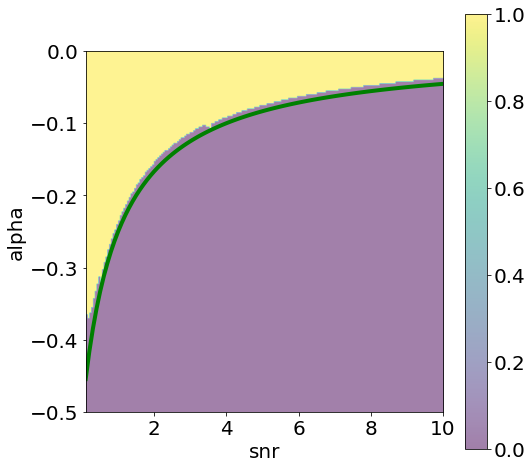

In [37]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] = '20'

plt.imshow(fusion_result,extent = [0.1,10,-0.5,0],aspect = 20,alpha = 0.5)
x = np.linspace(0.1,10,100)
plt.plot(x,-0.5*(1+x)**-1,linewidth=4,color = 'g')
plt.colorbar()
plt.xlabel('snr')
plt.ylabel('alpha')

plt.savefig('fus1.svg')